# SARIMA<br>(Seasonal Auto Regressive Integrated Moving Average)

SARIMA is used for non-stationary series. In this model, a differentiation step I (d) is used to eliminate non-stationarity.
The seasonality is modelled by its own set of ARIMA-parameters (seasonal parameters)

- **AR**: Auto regressive model (can be a simple, multiple or non-linear regression)
- **MA**: Moving averages model. The moving average models can use weighting factors, where the observations are weighted by a trim factor (for the oldest data in the series) and with a higher weight for the most recent observations.
- **I**: If the series has a tendency, it will be necessary to use the ARIMA model.


Therefore, the ARIMA model uses three different hyperparameters (in this order):

- p = number of lags / order of AR terms
- d = order of differencing
- q = number of lagged forecast errors / order of MA terms

Let's use the same flight-passengers data:

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib import rcParams

warnings.filterwarnings('ignore')
%matplotlib inline

plt.style.use('fivethirtyeight')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'G'
rcParams['figure.figsize'] = 16,8

#reading the dataset
train = pd.read_csv('AirPassengers.csv')

#preprocessing
train.timestamp = pd.to_datetime(train.Month , format = '%Y-%m')
train.index = train.timestamp
train.drop('Month',axis = 1, inplace = True)

Let's have a look onto our data again:

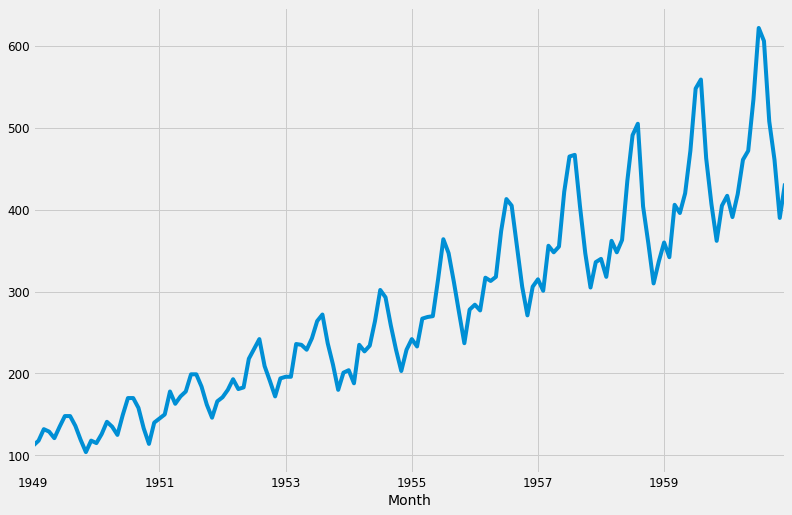

In [2]:
train['#Passengers'].plot(figsize=(12,8))

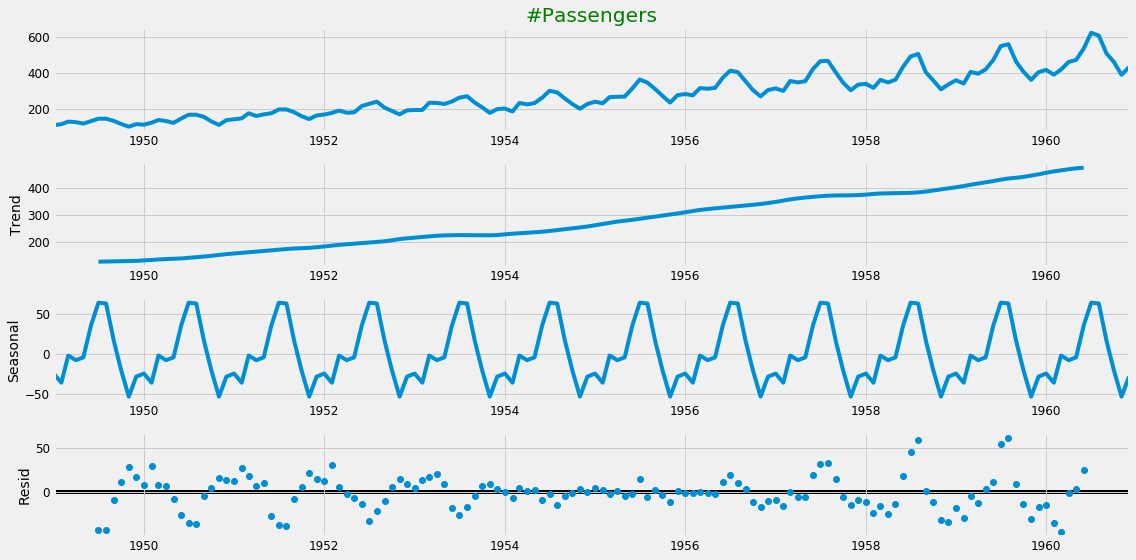

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts = train['#Passengers']
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

In [4]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
print('Amount of parameter combinations: ', len(seasonal_pdq)*len(pdq))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)
Amount of parameter combinations:  729


In [ ]:
bestAIC = 1500.0
bestParam = 'default'
bestSeasonalParam = 'default'

for param in tqdm(pdq):
    for param_seasonal in tqdm(seasonal_pdq, leave=False):
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            
            if results.aic < bestAIC:
                bestAIC = results.aic
                bestParam = str(param)
                bestSeasonalParam = str(param_seasonal)
        except: 
            continue
    print(bestParam, bestSeasonalParam, bestAIC)

In [5]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(2, 1, 2),
                                seasonal_order=(0, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0918      0.071    -15.427      0.000      -1.230      -0.953
ar.L2         -0.9589      0.071    -13.456      0.000      -1.099      -0.819
ma.L1          0.8785      0.108      8.160      0.000       0.667       1.089
ma.L2          0.9102      0.100      9.086      0.000       0.714       1.107
ma.S.L12      -1.6637    805.157     -0.002      0.998   -1579.743    1576.416
ma.S.L24       0.6638    534.296      0.001      0.999   -1046.538    1047.865
sigma2        85.8150   6.91e+04      0.001      0.999   -1.35e+05    1.36e+05


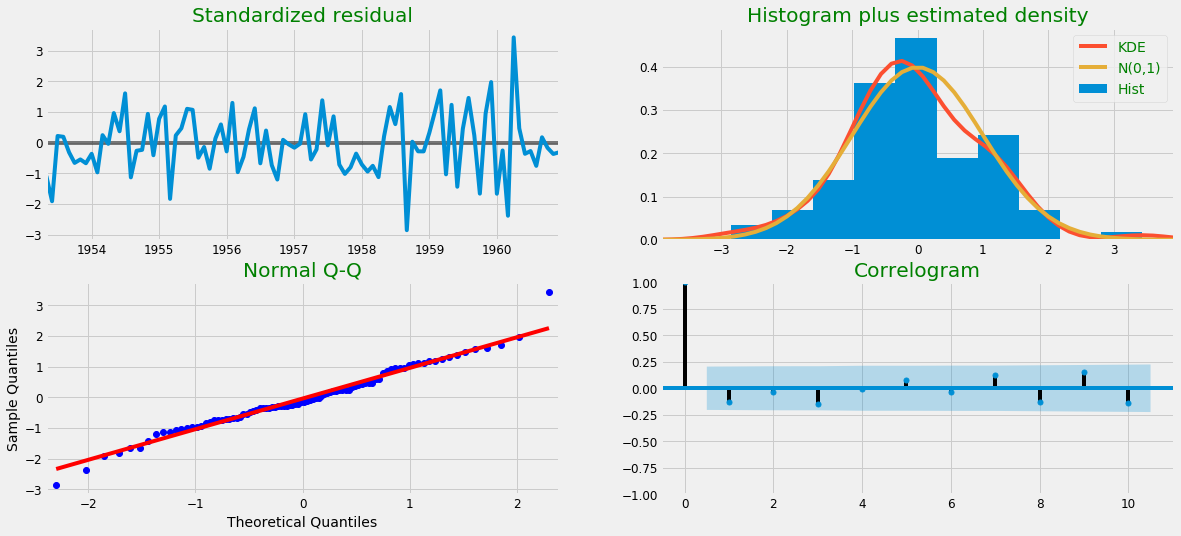

In [6]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

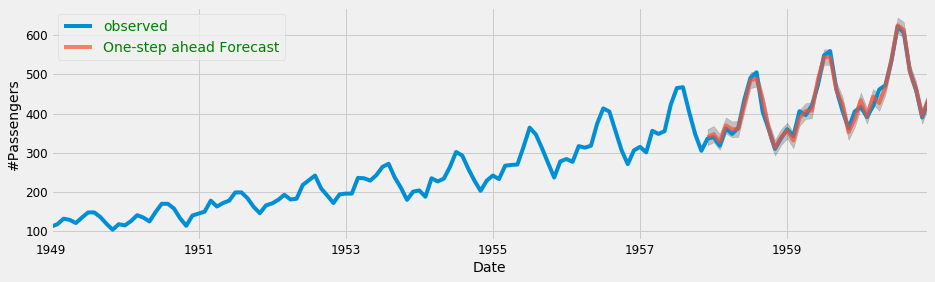

In [7]:
pred = results.get_prediction(start=pd.to_datetime('1957-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ts['1949-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('#Passengers')
plt.legend()
plt.show()

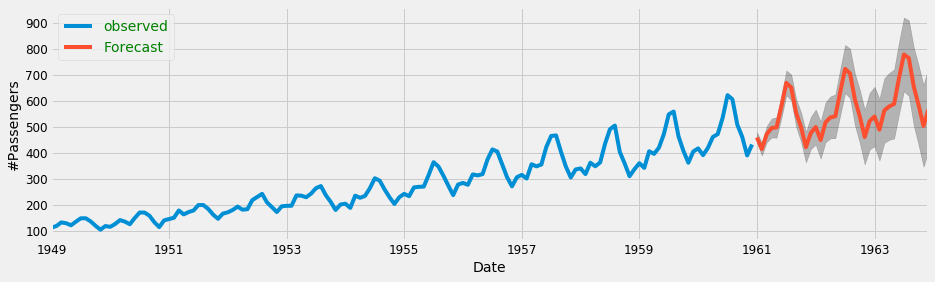

In [8]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = ts.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('#Passengers')
plt.legend()
plt.show()

# Outliers

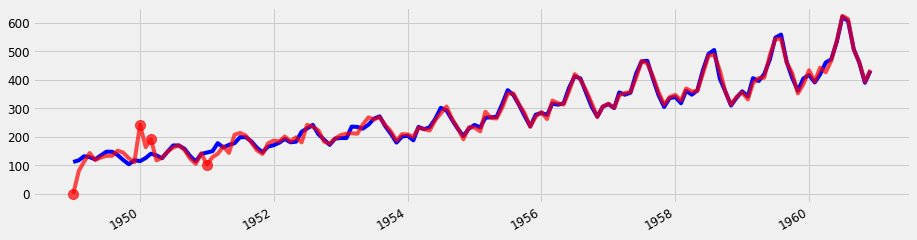

In [77]:
pred = results.get_prediction(start=pd.to_datetime('1949-01-01'), dynamic=False)
variance = ts - pred.predicted_mean.values
outliers = list(np.where(abs(variance) > mean+2*std, True, False))

fig, ax = plt.subplots()
plt.plot(ts.index, ts, c='blue')
pred.predicted_mean.plot(ax=ax, marker='o', markevery=outliers, label='One-step ahead Forecast', c='red', alpha=.7, figsize=(14, 4), ms=10)


plt.show()